In [1]:
!pip install transformers datasets torch scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
print(os.getcwd())

/content


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/ED_2/data/processed/train_set.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ED_2/data/processed/test_set.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/ED_2/data/processed/valid_set.csv')

train_texts = train_data['text_cleaned'].tolist()
train_labels = train_data['sensitive'].tolist()

test_texts = test_data['text_cleaned'].tolist()
test_labels = test_data['sensitive'].tolist()

valid_texts = valid_data['text_cleaned'].tolist()
valid_labels = valid_data['sensitive'].tolist()

In [6]:
# reduce train/test/valid data size to 10% of the original size
train_texts = train_texts[:int(len(train_texts)*0.1)]
train_labels = train_labels[:int(len(train_labels)*0.1)]
test_texts = test_texts[:int(len(test_texts)*0.1)]
test_labels = test_labels[:int(len(test_labels)*0.1)]
valid_texts = valid_texts[:int(len(valid_texts)*0.1)]
valid_labels = valid_labels[:int(len(valid_labels)*0.1)]

In [7]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
def tokenize_data(texts, labels, tokenizer, max_length=512):
    res = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt"), labels
    print("Tokenization done!")
    return res

train_encodings, train_labels = tokenize_data(train_texts, train_labels, tokenizer)
test_encodings, test_labels = tokenize_data(test_texts, test_labels, tokenizer)
valid_encodings, valid_labels = tokenize_data(valid_texts, valid_labels, tokenizer)

Tokenization done!
Tokenization done!
Tokenization done!


In [9]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch
from torch.utils.data import DataLoader, Dataset

class SensitiveDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SensitiveDataset(train_encodings, train_labels)
valid_dataset = SensitiveDataset(valid_encodings, valid_labels)

In [11]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lucijaaleksic16 (lucijaaleksic16-tu-wien). Use `wandb login --relogin` to force relogin


<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.178900,0.150770
2,0.074900,0.156258
3,0.034300,0.176167


<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct fro

TrainOutput(global_step=5328, training_loss=0.13310601901648952, metrics={'train_runtime': 4271.2445, 'train_samples_per_second': 19.948, 'train_steps_per_second': 1.247, 'total_flos': 1.1286619767687168e+16, 'train_loss': 0.13310601901648952, 'epoch': 3.0})

In [13]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(test_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

<ipython-input-10-463e8a6913ff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9460966542750929
Precision: 0.8823529411764706
Recall: 0.6912442396313364
F1: 0.7751937984496124


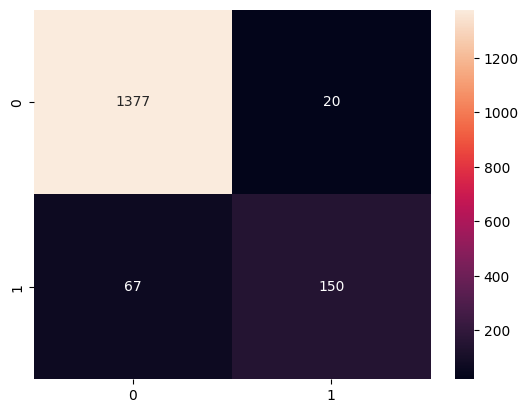

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

In [18]:
model.save_pretrained('/content/drive/MyDrive/ED_2/models/distilbert_model')